In [1]:
#Import Libraries

import os
import cv2
import numpy as np
import pandas as pd
import mahotas as mt
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from skimage import io, measure
import random

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split


In [2]:
# Access the dataset folder

AllDatasetDirPath = r"C:\Users\nashi\OneDrive\Documents\UW\4A Term\ECE 498A\CNN_Model\Project\Test"
FolderList = my_list = os.listdir(AllDatasetDirPath)
FolderList = FolderList[1:]
print(FolderList) 

['Dataset1', 'Dataset2', 'Dataset3']


In [3]:
def create_dataset():

    names = ['area','perimeter','physiological_length','physiological_width','aspect_ratio','rectangularity','circularity', 'major_axis', 'minor_axis', 'convex_area', 'convex_ratio', \
             'mean_r','mean_g','mean_b','stddev_r','stddev_g','stddev_b',  \
             'contrast','correlation','inverse_difference_moments','entropy', \
             'classlabel'
            ]
    
    AllDatasetResults=[]

    for i in FolderList:
        
        df = pd.DataFrame([], columns=names)

        print(FolderList.index(i), "/", len(FolderList), "Executing Dataset Name =", i)
        FolderName = i
        DATADIR = AllDatasetDirPath+"/"+FolderName # Outer Folder Path
        # print(DATADIR)

        df = pd.DataFrame([], columns=names)  # Create a new dataframe for each folder


        for dirname, _, filenames in os.walk(DATADIR):
            for filename in filenames:
                os.path.join(dirname, filename)

        CATEGORIES = os.listdir(DATADIR)[1:]
        print(CATEGORIES)

        for category in CATEGORIES:
            path=os.path.join(DATADIR, category)
            # print(path)
            myclass = CATEGORIES.index(category)
            img_files = os.listdir(path)
            # print(img_files)
            for file in img_files:
                if(file == ".DS_Store"):
                    continue
                imgpath = os.path.join(path, file)
                print(f"Reading image from: {imgpath}")
                main_img = cv2.imread(imgpath)
                print(f"main image from: {main_img}")



                # Creating target labels
                classlabel = myclass


                # Preprocessing

                # Convert the image to RGB
                print(main_img)
                img = cv2.cvtColor(main_img, cv2.COLOR_BGR2RGB)

                # Convert the image to Grayscale
                gray = cv2.cvtColor(main_img,cv2.COLOR_BGR2GRAY)

                # # Normalize the image
                # normalized_image = gray / 255.0

                # # Convert normalized image to uint8 for histogram equalization
                # normalized_image_uint8 = (normalized_image * 255).astype(np.uint8)

                # # Apply histogram equalization
                # equalized_image = cv2.equalizeHist(normalized_image_uint8)

                # # Apply Gaussian blur
                # blurred_image = cv2.GaussianBlur(equalized_image, (5, 5), 0)
                
                # # Apply Canny edge detection
                # edges = cv2.Canny(blurred_image, 100, 200)


                # # Perform thresholding
                _, thresholded = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)


                # # Apply morphological operations
                # kernel = np.ones((3, 3), np.uint8)
                # closing = cv2.morphologyEx(thresholded, cv2.MORPH_CLOSE, kernel)
                
                # # Resize the image
                # final_image = cv2.resize(closing, (80, 60))
                
                # # Convert grayscale to a 3-channel image
                # final_image = cv2.cvtColor(final_image, cv2.COLOR_GRAY2BGR)
                
                # # Prepare for model input
                # final_image = final_image.astype(np.float32) / 255.0
                # final_image = np.expand_dims(final_image, axis=0)
                
                # # Save the processed image for verification
                # saved_image =  cv2.imwrite('processed_image.jpg', (final_image[0] * 255).astype(np.uint8))

                # print(saved_image)




                
                # Find contours
                contours, _ = cv2.findContours(thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                
                # Get the largest contour (assumed to be the leaf)
                leaf_contour = max(contours, key=cv2.contourArea)
                

                # Shape based features
                x, y, w, h = cv2.boundingRect(leaf_contour)
                area = cv2.contourArea(leaf_contour)
                perimeter = cv2.arcLength(leaf_contour, True)
                x, y, w, h = cv2.boundingRect(leaf_contour)
                physiological_length = max(w, h)
                physiological_width = min(w, h)
                aspect_ratio = float(physiological_length) / physiological_width
                rectangularity = area / (physiological_length * physiological_width)
                circularity = (4 * np.pi * area) / (perimeter ** 2)
                convex_area = cv2.contourArea(cv2.convexHull(leaf_contour))
                convex_ratio = area / convex_area


                # Color based features
                b, g, r = cv2.split(img)

                # Calculate mean and standard deviation for each channel
                mean_b = np.mean(b)
                mean_g = np.mean(g)
                mean_r = np.mean(r)

                std_b = np.std(b)
                std_g = np.std(g)
                std_r = np.std(r)
            
                
                # Texture based features
                textures = mt.features.haralick(gray)
                ht_mean = textures.mean(axis=0)
                contrast = ht_mean[1]
                correlation = ht_mean[2]
                inverse_diff_moments = ht_mean[4]
                entropy = ht_mean[8]
                

                vector = [area,perimeter,physiological_length,physiological_width,aspect_ratio,rectangularity,circularity,w,h,convex_area,convex_ratio, \
                        mean_r,mean_g,mean_b,std_r,std_g,std_b,\
                        contrast,correlation,inverse_diff_moments,entropy,\
                        classlabel
                        ]
                
                df_temp = pd.DataFrame([vector],columns=names)
                df = pd.concat([df, df_temp])
                df = df.reset_index(drop=True)

                # Save the processed image
                processed_img_dir = "processed_images"
                if not os.path.exists(processed_img_dir):
                    os.makedirs(processed_img_dir)

                processed_img = gray / 255.0
                processed_img = (processed_img * 255).astype(np.uint8)
                print(processed_img)
                processed_img_path = os.path.join(processed_img_dir, f"{FolderName}_{category}_{file}")
                cv2.imwrite(processed_img_path, processed_img)
                #cv2.imwrite(r"C:\Users\nashi\OneDrive\Documents\UW\4A Term\ECE 498A\CNN_Model\Project\Test" + "saved_image.jpg", processed_img)


        AllDatasetResults.append(df)

        # #Conversion of dataframe to CSV
        # df.to_csv(f"{i}.csv")
    return AllDatasetResults
    

In [4]:
dataset = create_dataset()

0 / 3 Executing Dataset Name = Dataset1
['Category1', 'Category2']
Reading image from: C:\Users\nashi\OneDrive\Documents\UW\4A Term\ECE 498A\CNN_Model\Project\Test/Dataset1\Category1\mint copy.jpg
main image from: [[[0 1 1]
  [0 1 1]
  [0 1 1]
  ...
  [0 1 1]
  [0 1 1]
  [0 1 1]]

 [[0 1 1]
  [0 1 1]
  [0 1 1]
  ...
  [0 1 1]
  [0 1 1]
  [0 1 1]]

 [[0 1 1]
  [0 1 1]
  [0 1 1]
  ...
  [0 1 1]
  [0 1 1]
  [0 1 1]]

 ...

 [[0 1 1]
  [0 1 1]
  [0 1 1]
  ...
  [0 1 1]
  [0 1 1]
  [0 1 1]]

 [[0 1 1]
  [0 1 1]
  [0 1 1]
  ...
  [0 1 1]
  [0 1 1]
  [0 1 1]]

 [[0 1 1]
  [0 1 1]
  [0 1 1]
  ...
  [0 1 1]
  [0 1 1]
  [0 1 1]]]
[[[0 1 1]
  [0 1 1]
  [0 1 1]
  ...
  [0 1 1]
  [0 1 1]
  [0 1 1]]

 [[0 1 1]
  [0 1 1]
  [0 1 1]
  ...
  [0 1 1]
  [0 1 1]
  [0 1 1]]

 [[0 1 1]
  [0 1 1]
  [0 1 1]
  ...
  [0 1 1]
  [0 1 1]
  [0 1 1]]

 ...

 [[0 1 1]
  [0 1 1]
  [0 1 1]
  ...
  [0 1 1]
  [0 1 1]
  [0 1 1]]

 [[0 1 1]
  [0 1 1]
  [0 1 1]
  ...
  [0 1 1]
  [0 1 1]
  [0 1 1]]

 [[0 1 1]
  [0 1 1]
  [0 1

C:\Users\nashi\AppData\Local\Temp\ipykernel_14200\1728264828.py:152: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, df_temp])


[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]
Reading image from: C:\Users\nashi\OneDrive\Documents\UW\4A Term\ECE 498A\CNN_Model\Project\Test/Dataset1\Category1\mint.jpg
main image from: [[[0 1 1]
  [0 1 1]
  [0 1 1]
  ...
  [0 1 1]
  [0 1 1]
  [0 1 1]]

 [[0 1 1]
  [0 1 1]
  [0 1 1]
  ...
  [0 1 1]
  [0 1 1]
  [0 1 1]]

 [[0 1 1]
  [0 1 1]
  [0 1 1]
  ...
  [0 1 1]
  [0 1 1]
  [0 1 1]]

 ...

 [[0 1 1]
  [0 1 1]
  [0 1 1]
  ...
  [0 1 1]
  [0 1 1]
  [0 1 1]]

 [[0 1 1]
  [0 1 1]
  [0 1 1]
  ...
  [0 1 1]
  [0 1 1]
  [0 1 1]]

 [[0 1 1]
  [0 1 1]
  [0 1 1]
  ...
  [0 1 1]
  [0 1 1]
  [0 1 1]]]
[[[0 1 1]
  [0 1 1]
  [0 1 1]
  ...
  [0 1 1]
  [0 1 1]
  [0 1 1]]

 [[0 1 1]
  [0 1 1]
  [0 1 1]
  ...
  [0 1 1]
  [0 1 1]
  [0 1 1]]

 [[0 1 1]
  [0 1 1]
  [0 1 1]
  ...
  [0 1 1]
  [0 1 1]
  [0 1 1]]

 ...

 [[0 1 1]
  [0 1 1]
  [0 1 1]
  ...
  [0 1 1]
  [0 1 1]
  [0 1 1]]

 [[0 1 1]
  [0 1 1]
  [0 1 1]
  ...
  [0 1 1]


C:\Users\nashi\AppData\Local\Temp\ipykernel_14200\1728264828.py:152: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, df_temp])


[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]
Reading image from: C:\Users\nashi\OneDrive\Documents\UW\4A Term\ECE 498A\CNN_Model\Project\Test/Dataset2\Category1\mint.jpg
main image from: [[[0 1 1]
  [0 1 1]
  [0 1 1]
  ...
  [0 1 1]
  [0 1 1]
  [0 1 1]]

 [[0 1 1]
  [0 1 1]
  [0 1 1]
  ...
  [0 1 1]
  [0 1 1]
  [0 1 1]]

 [[0 1 1]
  [0 1 1]
  [0 1 1]
  ...
  [0 1 1]
  [0 1 1]
  [0 1 1]]

 ...

 [[0 1 1]
  [0 1 1]
  [0 1 1]
  ...
  [0 1 1]
  [0 1 1]
  [0 1 1]]

 [[0 1 1]
  [0 1 1]
  [0 1 1]
  ...
  [0 1 1]
  [0 1 1]
  [0 1 1]]

 [[0 1 1]
  [0 1 1]
  [0 1 1]
  ...
  [0 1 1]
  [0 1 1]
  [0 1 1]]]
[[[0 1 1]
  [0 1 1]
  [0 1 1]
  ...
  [0 1 1]
  [0 1 1]
  [0 1 1]]

 [[0 1 1]
  [0 1 1]
  [0 1 1]
  ...
  [0 1 1]
  [0 1 1]
  [0 1 1]]

 [[0 1 1]
  [0 1 1]
  [0 1 1]
  ...
  [0 1 1]
  [0 1 1]
  [0 1 1]]

 ...

 [[0 1 1]
  [0 1 1]
  [0 1 1]
  ...
  [0 1 1]
  [0 1 1]
  [0 1 1]]

 [[0 1 1]
  [0 1 1]
  [0 1 1]
  ...
  [0 1 1]


C:\Users\nashi\AppData\Local\Temp\ipykernel_14200\1728264828.py:152: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, df_temp])


[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]
Reading image from: C:\Users\nashi\OneDrive\Documents\UW\4A Term\ECE 498A\CNN_Model\Project\Test/Dataset3\Category1\mint.jpg
main image from: [[[0 1 1]
  [0 1 1]
  [0 1 1]
  ...
  [0 1 1]
  [0 1 1]
  [0 1 1]]

 [[0 1 1]
  [0 1 1]
  [0 1 1]
  ...
  [0 1 1]
  [0 1 1]
  [0 1 1]]

 [[0 1 1]
  [0 1 1]
  [0 1 1]
  ...
  [0 1 1]
  [0 1 1]
  [0 1 1]]

 ...

 [[0 1 1]
  [0 1 1]
  [0 1 1]
  ...
  [0 1 1]
  [0 1 1]
  [0 1 1]]

 [[0 1 1]
  [0 1 1]
  [0 1 1]
  ...
  [0 1 1]
  [0 1 1]
  [0 1 1]]

 [[0 1 1]
  [0 1 1]
  [0 1 1]
  ...
  [0 1 1]
  [0 1 1]
  [0 1 1]]]
[[[0 1 1]
  [0 1 1]
  [0 1 1]
  ...
  [0 1 1]
  [0 1 1]
  [0 1 1]]

 [[0 1 1]
  [0 1 1]
  [0 1 1]
  ...
  [0 1 1]
  [0 1 1]
  [0 1 1]]

 [[0 1 1]
  [0 1 1]
  [0 1 1]
  ...
  [0 1 1]
  [0 1 1]
  [0 1 1]]

 ...

 [[0 1 1]
  [0 1 1]
  [0 1 1]
  ...
  [0 1 1]
  [0 1 1]
  [0 1 1]]

 [[0 1 1]
  [0 1 1]
  [0 1 1]
  ...
  [0 1 1]


Found 5 images belonging to 3 classes.
Found 4 images belonging to 3 classes.
Found 4 images belonging to 1 classes.
Epoch 1/20


C:\Users\nashi\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 310ms/step - accuracy: 0.8375 - loss: 1.0519 - val_accuracy: 0.5000 - val_loss: 1.0672
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.7167 - loss: 1.0327 - val_accuracy: 0.2500 - val_loss: 1.1343
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.1625 - loss: 1.2522 - val_accuracy: 0.2500 - val_loss: 1.1326
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.4500 - loss: 1.0972 - val_accuracy: 0.2500 - val_loss: 1.0961
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.2833 - loss: 1.4139 - val_accuracy: 0.2500 - val_loss: 1.0867
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.7167 - loss: 1.0659 - val_accuracy: 0.2500 - val_loss: 1.0915
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.2833 - loss: 1.0614 - val_accuracy: 0.2500 - val_loss: 1.1000
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.5750 - loss: 1.0622 - val_accuracy: 0.2500 - val_loss: 1.1060
Epoch 9/20

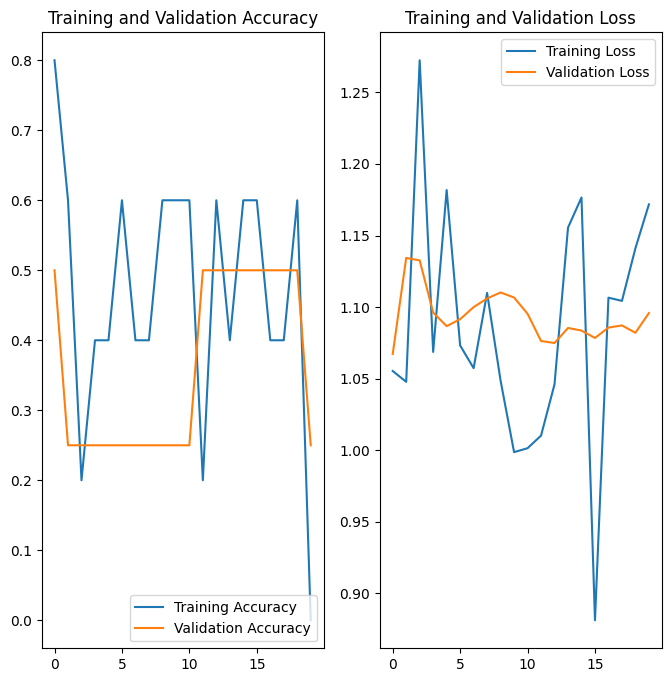

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.0000e+00 - loss: 3.3382 
Test loss: 3.3382489681243896
Test accuracy: 0.0


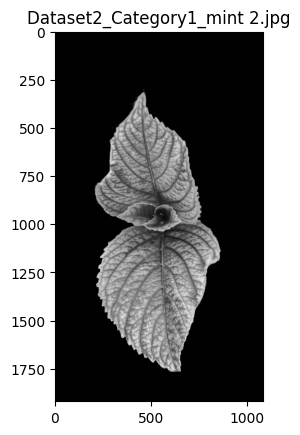

This image most likely belongs to Dataset2 with a 57.61 percent confidence.


In [5]:
# Paths to training and validation directory
training_path = r'C:\Users\nashi\OneDrive\Documents\UW\4A Term\ECE 498A\CNN_Model\processed_images\Training'
validation_path = r'C:\Users\nashi\OneDrive\Documents\UW\4A Term\ECE 498A\CNN_Model\processed_images\Validation'
test_path = r'C:\Users\nashi\OneDrive\Documents\UW\4A Term\ECE 498A\CNN_Model\processed_images\Testing'

# Perform image augmentation on training and validation images
train_image = ImageDataGenerator(
    rescale=1/255,
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.1,
    horizontal_flip=True
)

validation_image = ImageDataGenerator(rescale=1/255)

test_image = ImageDataGenerator(rescale=1/255)


# Initialize generators for training, validation, and test set
train_generator = train_image.flow_from_directory(
    training_path,
    target_size=(80, 60),  
    color_mode = 'grayscale',
    batch_size=2,
    class_mode='categorical' 
)

validation_generator = validation_image.flow_from_directory(
    validation_path,
    target_size=(80, 60),  
    color_mode = 'grayscale',
    batch_size=2,
    class_mode='categorical'
)

test_generator = test_image.flow_from_directory(
    test_path,
    target_size=(80, 60),  
    color_mode = 'grayscale',
    batch_size=2,
    class_mode='categorical'
)


# Define the CNN Model
model = Sequential([
    Input(shape=(80, 60, 1)), #Define the input image as 80 height, 60 width, and 1 channel for greyscale images
    Conv2D(16, (3, 3), activation='relu'), #Convolutional layer with 16 filters of size 3*3
    MaxPooling2D((2, 2)), #Max pooling layer of size 2*2
    Conv2D(32, (3, 3), activation='relu'), #Convolutional layer with 32 filters of size 3*3
    MaxPooling2D((2, 2)), #Max pooling layer of size 2*2
    Conv2D(64, (3, 3), activation='relu'), #Convolutional layer with 64 filters of size 3*3
    MaxPooling2D((2, 2)), #Max pooling layer of size 2*2
    Flatten(), #Flatten the 3D outputs to 1D
    Dense(128, activation='relu'), #Fully connected layer with 128 neurons
    Dropout(0.5), #Sets 50% of the neurons to 0 to prevent the model from "memorizing" the images
    Dense(3, activation='softmax')  # Output layer with softmax activation function for multi-classification
])

# Compile the CNN model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#model.summary()

epochs = 20
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=epochs
)

# Display the results of training
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#Evaluate on test set
score = model.evaluate(test_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

#Choose random image from test set
test_image_path = r"C:\Users\nashi\OneDrive\Documents\UW\4A Term\ECE 498A\CNN_Model\processed_images\Testing\Test_Folder"
random_image = random.choice(os.listdir(test_image_path)) # select random image from test dataset
random_image_path = os.path.join(test_image_path, random_image) # get complete path to random image
predicted_image = mpimg.imread(random_image_path) #read image
image_plot = plt.imshow(predicted_image, cmap = 'gray') #display image as greyscale
plt.title(random_image)
plt.show() #display image

#Create a list of classes from folder in training directory
class_names = os.listdir(training_path)
#print(class_names)

#load random image from test dataset
img= tf.keras.utils.load_img(
    random_image_path,
    color_mode='grayscale',
    target_size=(80,60)
)

img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) 

#Make prediction on random image
predictions = model(img_array)
score = tf.nn.softmax(predictions[0])
print("This image most likely belongs to {} with a {:.2f} percent confidence.".format(class_names[np.argmax(score)], 100 * np.max(score)))

